In [2]:
%matplotlib notebook
DEFAULT_FIGSIZE = (12, 8)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint
from antlia import trial2

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

In [3]:
with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

bicycle_record_files = [
    '2018-04-23_12-30-38.csv',
    '2018-04-23_13-13-36.csv',
    '2018-04-23_14-22-58.csv',
    '2018-04-23_15-27-48.csv',
    '2018-04-23_16-32-27.csv',
    '2018-04-23_17-14-00.csv',
    '2018-04-25_09-27-24.csv',
    '2018-04-25_10-20-28.csv',
    '2018-04-25_11-34-04.csv',
    '2018-04-25_12-41-48.csv',
    '2018-04-25_14-14-57.csv',
    '2018-04-25_14-49-39.csv',
    '2018-04-25_16-15-57.csv',
    '2018-04-25_17-23-04.csv',
    '2018-04-26_11-19-31.csv',
    '2018-04-26_14-50-53.csv',
    '2018-04-27_14-59-52.csv'
]

lidar_record_files = [
    '2018-04-23-12-17-37_0.pkl.gz',
    '2018-04-23-13-01-00_0.pkl.gz',
    '2018-04-23-14-10-33_0.pkl.gz',
    '2018-04-23-15-15-14_0.pkl.gz',
    '2018-04-23-16-19-35_0.pkl.gz',
    '2018-04-23-17-01-24_0.pkl.gz',
    '2018-04-25-09-15-00_0.pkl.gz',
    '2018-04-25-10-07-31_0.pkl.gz',
    '2018-04-25-11-21-29_0.pkl.gz',
    '2018-04-25-12-29-06_0.pkl.gz',
    '2018-04-25-14-02-15_0.pkl.gz',
    '2018-04-25-14-36-55_0.pkl.gz',
    '2018-04-25-16-03-24_0.pkl.gz',
    '2018-04-25-17-10-07_0.pkl.gz',
    '2018-04-26-11-07-38_0.pkl.gz',
    '2018-04-26-14-38-03_0.pkl.gz',
    '2018-04-27-14-47-07_0.pkl.gz',
    '2018-04-27-15-39-56_0.pkl.gz'
]

records = []
data_dir = '../../data/comfort'
i = 0
for file1, file2 in zip(bicycle_record_files, lidar_record_files):
    r1 = load_file(os.path.join(data_dir, file1), bicycle_calibration['convbike'])
    r2 = load_converted_record(os.path.join(data_dir, file2))
    r = Record(r2, r1)
    records.append(r)
    print('loaded record from files: {}, {}'.format(file1, file2))
    i += 1
    #if i >= 8:
    if i >= 0:
        break

loaded record from files: 2018-04-23_12-30-38.csv, 2018-04-23-12-17-37_0.pkl.gz


In [4]:
# notes on missing syncs and repeated trials
missing_sync = [
   [680], None, None, None, None,
   None, None, None, None, None,
   None, None, None, None, None,
   None, None
]

trial_mask = [
   None, None, 0, None, None,
   0, None, None, 9, None,
   None, 11, 8, 9, None,
   None, None
]

#assert len(missing_sync) == len(records)

for i, (r, ms, tm) in enumerate(zip(records, missing_sync, trial_mask)):
    print('calculating trials for cyclist', i)
    
    try:
        r.sync()
        r._calculate_trials2(missing_sync=ms, trial_mask=tm)
    except (AssertionError, ValueError) as e:
        print('unable to calculate trials for cyclist', i)
        print(e)

calculating trials for cyclist 0


In [5]:
import IPython.display
import sympy
import sympy.physics.vector as vec
vec.init_vprinting(use_latex='mathjax')

def idisplay(string, *args):
    if isinstance(string, str):
        string = string.format(*[vec.vlatex(a) for a in args])
        display(IPython.display.Math(string))
    else:
        display(string, *args)

px, py, yaw, v = vec.dynamicsymbols('p_x, p_y, psi, v')
state = sympy.Matrix([px, py, yaw, v, yaw.diff(), v.diff()])
idisplay('{} = {}', sympy.Symbol('xvec'), state)

<IPython.core.display.Math object>

In [6]:
import sympy.physics.mechanics as mec

t_k, t_k1 = sympy.symbols('t_k, t_k+1', real=True)
t = vec.dynamicsymbols._t
dt = sympy.Symbol('\Delta t')

dstate = sympy.Matrix([
    v*sympy.cos(yaw),
    v*sympy.sin(yaw),
    yaw.diff(),
    v.diff(),
    0,
    0
])

dv_k = sympy.Symbol('\dot{v}_k', nonzero=True)
dyaw_k = sympy.Symbol('\dot{\psi}_k', nonzero=True)
state_const_items = {
    v.diff(): dv_k,
    yaw.diff(): dyaw_k,
}
idisplay('{} = {} + {}',
         sympy.Symbol('xvec_k+1'),
         sympy.Symbol('xvec_k'),
         sympy.integrate(dstate.subs(state_const_items),
                         (t, t_k, t_k1)).simplify().subs(
             t_k1 - t_k, dt))

<IPython.core.display.Math object>

In [359]:
v_k = sympy.Symbol('v_k')
yaw_k = sympy.Symbol('\psi_k')
state_func_items = {
    v: v_k,
    #v: v_k + dv_k*(t - t_k),
    yaw: yaw_k + dyaw_k*(t - t_k),
}

def simplify_elem_dt(x):
    return x.subs({
        t_k1: dt + t_k
    }).expand()


print('using: ')
display(state_func_items)

dstate_int = sympy.integrate(
    dstate.subs(state_const_items).subs(state_func_items),
    (t, t_k, t_k1)).applyfunc(simplify_elem_dt)

idisplay('{} = {} + {}',
         sympy.Symbol('xvec_k+1'),
         sympy.Symbol('xvec_k'),
         dstate_int)

using: 


{ψ: \dot{\psi}ₖ⋅(t - tₖ) + \psiₖ, v: vₖ}

<IPython.core.display.Math object>

In [360]:
state_func_items = {
    v: v_k,
    #v: v_k + dv_k*(t - t_k),
    yaw: yaw_k,
}

print('using: ')
display(state_func_items)
idisplay('{} = 0', dyaw_k)

dstate_int_0 = sympy.integrate(
    dstate.subs(state_const_items).subs(state_func_items).subs(dyaw_k, 0),
    (t, t_k, t_k1)).applyfunc(simplify_elem_dt)

idisplay('{} = {} + {}',
         sympy.Symbol('xvec_k+1'),
         sympy.Symbol('xvec_k'),
         dstate_int_0)

using: 


{ψ: \psiₖ, v: vₖ}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [361]:
w = sympy.symbols('w')
measurement = sympy.Matrix([
    px + w*sympy.cos(yaw)/2,
    py + w*sympy.sin(yaw)/2,
    yaw.diff(),
    v.diff()
])

print('measurement function h is:')
display(measurement)

measurement function h is:


⎡w⋅cos(ψ)      ⎤
⎢──────── + pₓ ⎥
⎢   2          ⎥
⎢              ⎥
⎢w⋅sin(ψ)      ⎥
⎢──────── + p_y⎥
⎢   2          ⎥
⎢              ⎥
⎢      ψ̇      ⎥
⎢              ⎥
⎣      v̇      ⎦

In [362]:
# http://campar.in.tum.de/Chair/KalmanFilter
# http://www.robots.ox.ac.uk/~ian/Teaching/Estimation/LectureNotes2.pdf
# https://github.com/balzer82/Kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb?create=1
# https://winfriedauner.de/projects/unscented/ctrv/

# for now, ignore W, V

yaw_rate_tol = 0.01

state_lam = [px, py, yaw_k, v_k, dyaw_k, dv_k]

dx_f_0_lam = sympy.lambdify([dt] + state_lam, dstate_int_0, modules='numpy')
dx_f_lam = sympy.lambdify([dt] + state_lam, dstate_int, modules='numpy')

J_A_0 = dstate_int_0.jacobian(state_lam)
J_A_0_lam = sympy.lambdify([dt] + state_lam, J_A_0, modules='numpy')
J_A = dstate_int.jacobian(state_lam)
J_A_lam = sympy.lambdify([dt] + state_lam, J_A, modules='numpy')

h_H_xreplace = {
    yaw: yaw_k,
    v: v_k,
    yaw.diff(): dyaw_k,
    v.diff(): dv_k,
}
z_h_lam = sympy.lambdify([w] + state_lam,
                         measurement.xreplace(h_H_xreplace),
                         modules='numpy')

J_H = measurement.jacobian(state)
J_H_lam = sympy.lambdify([w] + state_lam,
                         J_H.xreplace(h_H_xreplace),
                         modules='numpy')

def f(state_vector, sample_time=1/20):
    assert len(state_vector) == len(state)
    state_k = [yaw_k, v_k, dyaw_k, dv_k]
    state_subs = dict(zip(state_k, state_vector[2:]))
    state_subs[dt] = sample_time
    
    # check yaw_rate
    if abs(state_subs[dyaw_k]) < yaw_rate_tol:
        dx = dx_f_0_lam
    else:
        dx = dx_f_lam
    f = dx(sample_time, *state_vector).squeeze() + state_vector.squeeze()
    return f

def A(state_vector, sample_time=1/20):
    assert len(state_vector) == len(state)
    
    # check yaw_rate
    if abs(state_vector[4]) < yaw_rate_tol:
        dx = J_A_0_lam
    else:
        dx = J_A_lam
    A = np.eye(6) + dx(sample_time, *state_vector)
    return A

def h(state_vector, wheelbase=1):
    return z_h_lam(wheelbase, *state_vector).squeeze()

def H(state_vector, wheelbase=1):
    return J_H_lam(wheelbase, *state_vector)

x = np.zeros(6,)
display(f(x))
display(A(x))
display(h(x))
display(H(x))

array([ 0.,  0.,  0.,  0.,  0.,  0.])

array([[ 1.  ,  0.  ,  0.  ,  0.05,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.05],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ]])

array([ 0.5,  0. ,  0. ,  0. ])

array([[ 1. ,  0. , -0. ,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ]])

In [399]:
import collections

KalmanResult = collections.namedtuple(
    'KalmanResult', ['state_estimate',
                     'error_covariance',
                     'kalman_gain',
                     'predicted_state_estimate',
                     'predicted_error_covariance'])

def kalman(f, A, h, H, x0, P0, Q, R, z, progress=False):
    n = x0.shape[0] # state size
    l = z.shape[1] # measurement size
    N = z.shape[0] # number of samples
    
    x_hat_ = np.zeros((N, n, 1))
    P_ = np.zeros((N, n, n))
    x_hat = x_hat_.copy()
    P = P_.copy()
    K = np.zeros((N, n, l))
    
    x_hat[-1] = x0.copy().reshape((-1, 1))
    P[-1] = P0.copy()
    
    for k in range(N):
        # time update
        x_hat_[k] = f(x_hat[k - 1]).reshape((-1, 1))
        A_k = A(x_hat_[k])
        P_[k] = A_k@P[k - 1]@A_k.T + Q
        
        # measurement update 
        H_k = H(x_hat_[k], wheelbase=0)
        
        if np.ma.is_masked(z[k]):
            H_k[:2, :] = 0
            
        R_ = R.copy()
        d = np.sqrt(x_hat_[k, 0]**2 + x_hat_[k, 1]**2)
        R_[0, 0] += 0.01*(d/30)**2
        R_[1, 1] += 0.1*(d/30)**2
        
        S_k = H_k@P_[k]@H_k.T + R_
        K[k] = np.linalg.solve(S_k.T, (P_[k]@H_k.T).T).T
        x_hat[k] = x_hat_[k] + K[k]@(z[k].data - h(x_hat_[k], wheelbase=0)).reshape((-1, 1))
        P[k] = (np.eye(n) - K[k]@H_k)@P_[k]
        
        if progress:
            # print progress bar
            percent = int(np.ceil(k/(N + 1)*1000))
            s = '='*(percent//10) + ' '*(100 - percent//10)
            sys.stdout.write('\r')
            sys.stdout.write('[{}] {}%'.format(s, percent/10))
            sys.stdout.flush()
        
    return KalmanResult(x_hat, P, K, x_hat_, P_)

In [395]:
evt = records[0].trials[0].event
gyroz = evt.bicycle['gyroscope z']
accx = evt.bicycle['accelerometer x']

def measurement_array(event):
    z = np.ma.zeros((evt.bicycle.time.shape[0], 4))
    z[:, :2] = np.ma.masked
    z[:, 2] = evt.bicycle['gyroscope z'] - gyroz0
    z[:, 3] = -evt.bicycle['accelerometer x'] - accx0
    
    x, y = evt.trajectory(mode='raw')
    # mask out erroneous points
    xd = np.diff(x)
    y[:-1][xd > xd.std()] = np.ma.masked
    x[:-1][xd > xd.std()] = np.ma.masked
    
    
    # set gps to closest index
    index = np.searchsorted(evt.bicycle.time, evt.lidar.time) - 1
    z[index, 0] = x
    z[index, 1] = y
    return z

0.726572388048
0.726572388048


<IPython.core.display.Javascript object>


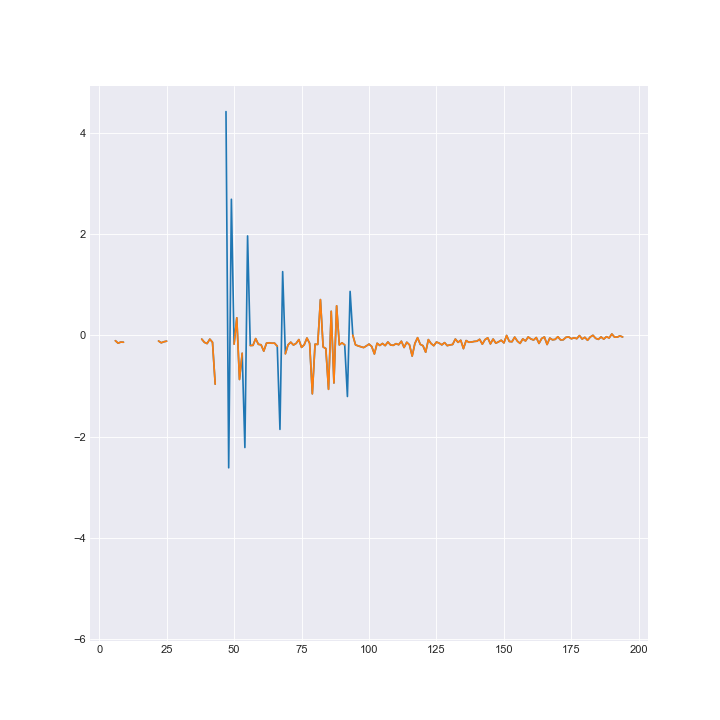

In [411]:
trjx = evt.trajectory(mode='raw')[0]

print(np.diff(trjx).std())


print(np.diff(trjx).std())
plt.close('all')
fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(np.diff(trjx))

trjxd = np.diff(trjx)
trjx[:-1][trjxd > trjxd.std()] = np.ma.masked

ax.plot(np.diff(trjx))
plt.show()

[=================================================================================================== ] 99.9%

<IPython.core.display.Javascript object>


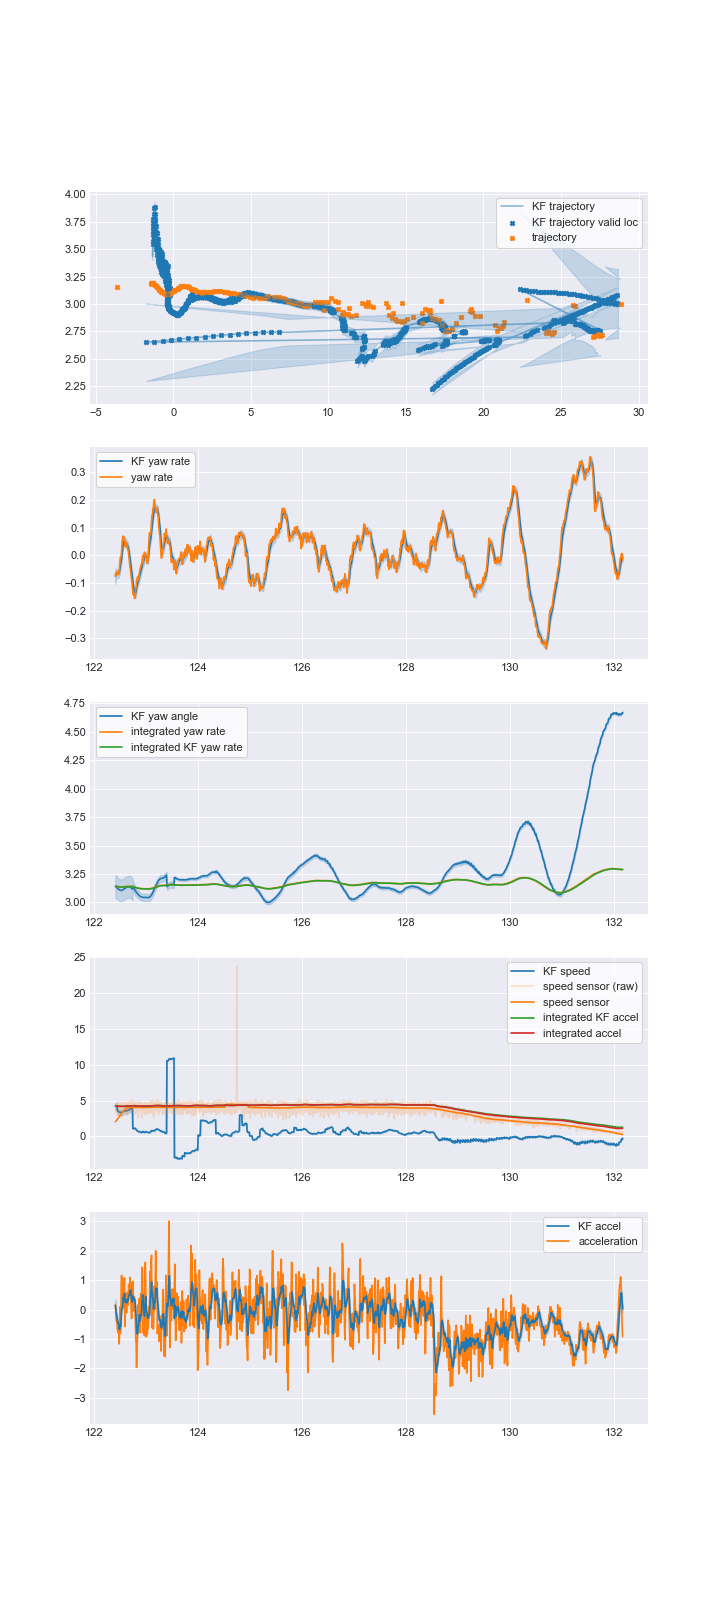

In [400]:
trjx, trjy = evt.trajectory(mode='interp')

T = 1/125 # bicycle sample rate
z = measurement_array(evt)
x0 = np.array([
    trjx[0],
    trjy[0],
    np.pi,
    abs((trjx[1] - trjx[0])*20),
    0,
    0
])
P0 = np.diag([
    0.1,
    0.1,
    0.01,
    0.2,
    0.1,
    0.2
])
Q = 1*np.diag([
    0.1*4*T**3/3, # [m] x-position
    0.1*4*T**3/3, # [m] y-position
    0.01*T**2/2, # [rad/s] yaw angle
    0.1*4*T**2/2, # [m/s] velocity 
    0.01*T, # [rad/s] yaw rate
    0.1*4*T, # [m/s^2] acceleration
])
R = np.diag([
    0.001, # x
    0.001, # y
    0.1*z[:100, 2].var(),
    0.1*z[:100, 3].var(),
])

result = kalman(f, A, h, H, x0, P0, Q, R, z, progress=True)

import scipy.integrate
from antlia import filter as ff

color = sns.color_palette('tab10', 10)

x = result[0]
P = result[1]

plt.close('all')
fig, ax = plt.subplots(5, 1, figsize=(9, 20))
ax[0].plot(x[:, 0], x[:, 1], alpha=0.5, label='KF trajectory')
index = z.mask.any(axis=1)
ax[0].scatter(x[index, 0],
              x[index, 1],
              s=15, marker='X',
              color=color[0],
              label='KF trajectory valid loc')
ax[0].scatter(z[:, 0].compressed(),
              z[:, 1].compressed(),
              s=15, marker='X',
              color=color[1],
              label='trajectory')
ax[0].fill_between(x[:, 0].squeeze(),
                   x[:, 1].squeeze() + np.sqrt(P[:, 1, 1]),
                   x[:, 1].squeeze() - np.sqrt(P[:, 1, 1]),
                   color=color[0], alpha=0.2)
ax[0].legend()

ax[1].plot(evt.bicycle.time, x[:, 4], label='KF yaw rate')
ax[1].plot(evt.bicycle.time, z[:, 2], label='yaw rate')
ax[1].fill_between(evt.bicycle.time,
                   x[:, 4].squeeze() + np.sqrt(P[:, 4, 4]),
                   x[:, 4].squeeze() - np.sqrt(P[:, 4, 4]),
                   color=color[0], alpha=0.2)
ax[1].legend()

ax[2].plot(evt.bicycle.time, x[:, 2],
           label='KF yaw angle')
ax[2].plot(evt.bicycle.time[1:],
           scipy.integrate.cumtrapz(z[:, 2], dx=T) + np.pi,
           label='integrated yaw rate')
ax[2].plot(evt.bicycle.time[1:],
           scipy.integrate.cumtrapz(x[:, 4].squeeze(), dx=T) + np.pi,
           label='integrated KF yaw rate')
ax[2].fill_between(evt.bicycle.time,
                   x[:, 2].squeeze() + np.sqrt(P[:, 2, 2]),
                   x[:, 2].squeeze() - np.sqrt(P[:, 2, 2]),
                   color=color[0], alpha=0.2)
ax[2].legend()

ax[3].plot(evt.bicycle.time, x[:, 3], color=color[0], label='KF speed')
#ylim = ax[3].get_ylim()
ax[3].plot(evt.bicycle.time, evt.bicycle.speed,
           color=color[1], alpha=0.2, label='speed sensor (raw)')
ax[3].plot(evt.bicycle.time, ff.moving_average(evt.bicycle.speed, 55),
           color=color[1], label='speed sensor')
ax[3].plot(evt.bicycle.time[1:],
           scipy.integrate.cumtrapz(x[:, 5].squeeze(), dx=T) + x0[3],
           color=color[2], label='integrated KF accel')
ax[3].plot(evt.bicycle.time[1:],
           scipy.integrate.cumtrapz(z[:, 3], dx=T) + x0[3],
           color=color[3], label='integrated accel')
ax[3].fill_between(evt.bicycle.time,
                   x[:, 3].squeeze() + np.sqrt(P[:, 3, 3]),
                   x[:, 3].squeeze() - np.sqrt(P[:, 3, 3]),
                   color=color[0], alpha=0.2)
#ax[3].set_ylim(ylim)
ax[3].legend()


ax[4].plot(evt.bicycle.time, x[:, 5],
           zorder=2,
           color=color[0], label='KF accel')
ax[4].fill_between(evt.bicycle.time,
                   x[:, 5].squeeze() + np.sqrt(P[:, 5, 5]),
                   x[:, 5].squeeze() - np.sqrt(P[:, 5, 5]),
                   color=color[0], alpha=0.2)
ax[4].plot(evt.bicycle.time, z[:, 3],
           zorder=1,
           color=color[1], label='acceleration')
ax[4].legend()
plt.show()

<IPython.core.display.Javascript object>


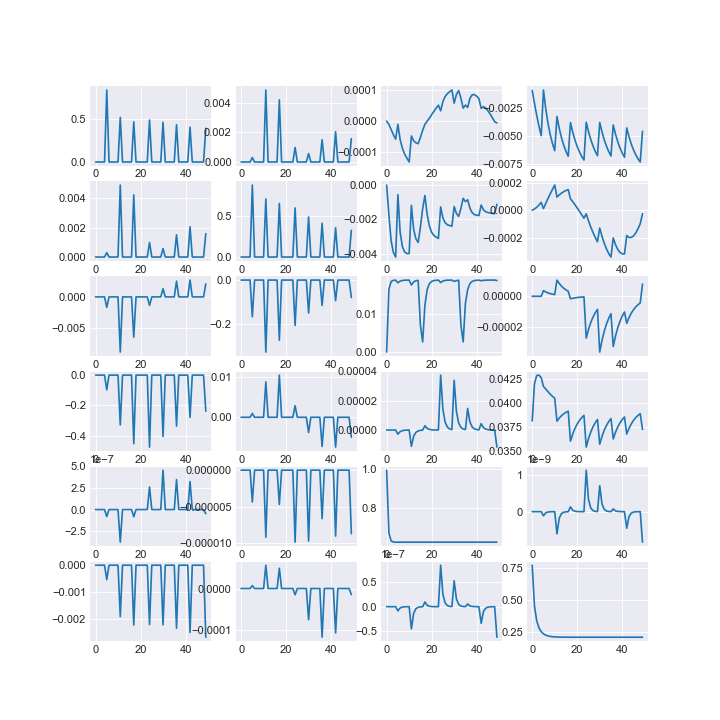

In [318]:
plt.close('all')

K = result.kalman_gain
fig, ax = plt.subplots(K.shape[1], K.shape[2], figsize=(9, 9))
for i in range(K.shape[1]):
    
    for j in range(K.shape[2]):
        ax[i, j].plot(K[:50, i, j])
        
plt.show()